- [Main code](#main-code)
- [Step by step code flow](step-by-step-code-flow)
- [Another way using transformers](another-way-using-transformers)
- [Optional](#optional)

### Main code

In [45]:
import sys
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

df_train = df.sample(frac=0.8, random_state=0)
df_val = df.drop(index=df_train.index)

cv = CountVectorizer(max_features=1000)
messages_train = cv.fit_transform(df_train["message"])
messages_val = cv.transform(df_val["message"])

X_train = torch.tensor(messages_train.todense(), dtype=torch.float32)
y_train = torch.tensor(df_train["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

X_val = torch.tensor(messages_val.todense(), dtype=torch.float32)
y_val = torch.tensor(df_val["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(1000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss)

def evaluate_model(X, y): 
    model.eval()
    with torch.no_grad():
        y_pred = nn.functional.sigmoid(model(X)) > 0.25
        print("accuracy:", (y_pred == y)\
            .type(torch.float32).mean())
        
        print("sensitivity:", (y_pred[y == 1] == y[y == 1])\
            .type(torch.float32).mean())
        
        print("specificity:", (y_pred[y == 0] == y[y == 0])\
            .type(torch.float32).mean())

        print("precision:", (y_pred[y_pred == 1] == y[y_pred == 1])\
            .type(torch.float32).mean()) 
        
print("Evaluating on the training data")
evaluate_model(X_train, y_train)

print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

custom_messages = cv.transform([
    "We have release a new product, do you want to buy it?", 
    "Winner! Great deal, call us to get this product for free",
    "Tomorrow is my birthday, do you come to the party?"
])

X_custom = torch.tensor(custom_messages.todense(), dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred = nn.functional.sigmoid(model(X_custom))
    print(pred)

tensor(0.6925, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2246, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1637, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1363, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1201, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1092, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1011, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0949, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0899, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0857, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Evaluating on the training data
accuracy: tensor(0.9789)
sensitivity: tensor(0.9211)
specificity: tensor(0.9881)
precision: tensor(0.9241)
Evaluating on the validation data
accuracy: tensor(0.9749)
sensitivity: tensor(0.9137)
specificity: tensor(0.9836)
precision: tensor(0.8881)
tensor([[0.0518],
        [0.6129],
        [0.0134]])


### Step by step code flow

First lets explore what is the dataset

In [1]:
import pandas as pd

df = pd.read_csv("./data/SMSSpamCollection")
df.head()

ParserError: Error tokenizing data. C error: Expected 2 fields in line 12, saw 4


As it was not csv by default, we need to handle the data correctly..

In [2]:
df = pd.read_csv("./data/SMSSpamCollection", sep="\t")
df.head()

,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


It was taking the 1st entry into the label

In [3]:
df = pd.read_csv("./data/SMSSpamCollection", sep="\t", names=["type", "message"])
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.iloc[0]

type                                                     ham
message    Go until jurong point, crazy.. Available only ...
Name: 0, dtype: object

In [5]:
df.iloc[0]["message"]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [6]:
df.iloc[2]["message"]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

How to know which message is spam. We can know it by checking type..

In [7]:
df["type"] == "spam"

0       False
1       False
2        True
3       False
4       False
        ...  
5567     True
5568    False
5569    False
5570    False
5571    False
Name: type, Length: 5572, dtype: bool

To make the neuron learn easily, we can keep 0,1 in the column instead of ham and spam

In [8]:
df["spam"] = df["type"] == "spam"
df

,type,message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,True
5568,ham,Will ü b going to esplanade fr home?,False
5569,ham,"Pity, * was in mood for that. So...any other s...",False
5570,ham,The guy did some bitching but I acted like i'd...,False


So now we dont need type column

In [9]:
df["spam"] = df["type"] == "spam"
df.drop("type", axis=1)
df.head()

,type,message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False


It didn't drop correctly

In [10]:
df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)
df.head()

,message,spam
0,"Go until jurong point, crazy.. Available only ...",False
1,Ok lar... Joking wif u oni...,False
2,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,U dun say so early hor... U c already then say...,False
4,"Nah I don't think he goes to usf, he lives aro...",False


In [11]:
print("Number of SPAM messages:")
print(len(df[df["spam"]==True]))

Number of SPAM messages:
747


In [12]:
print("Number of Not SPAM messages:")
print(len(df[df["spam"]==False]))

Number of Not SPAM messages:
4825


Lets learn how CountVectorizer works

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=6)
documents = [
    "Hello world. Today is amazing. Hello hello",
    "Hello mars, today is perfect"
]
cv.fit(documents)
print(cv.get_feature_names_out())
out = cv.transform(documents)
print("=======")
print(out)
print("=======")
print(out.todense())

['amazing' 'hello' 'is' 'mars' 'perfect' 'today']
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 9 stored elements and shape (2, 6)>
  Coords	Values
  (0, 0)	1
  (0, 1)	3
  (0, 2)	1
  (0, 5)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
[[1 3 1 0 0 1]
 [0 1 1 1 1 1]]


In [14]:
cv = CountVectorizer(max_features=7) # Change this from 1 to 7.  even if you increase beyond 7, it will not change because there are only 7 unique words here
documents = [
    "Hello world. Today is amazing. Hello hello",
    "Hello mars, today is perfect"
]
cv.fit(documents)
print(cv.get_feature_names_out())
out = cv.transform(documents)
print("=======")
print(out)
print("=======")
print(out.todense())

['amazing' 'hello' 'is' 'mars' 'perfect' 'today' 'world']
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 10 stored elements and shape (2, 7)>
  Coords	Values
  (0, 0)	1
  (0, 1)	3
  (0, 2)	1
  (0, 5)	1
  (0, 6)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
[[1 3 1 0 0 1 1]
 [0 1 1 1 1 1 0]]


Lets apply this CountVectorizer to our problem

In [15]:
cv = CountVectorizer(max_features=1000)
messages = cv.fit_transform(df["message"])
print(messages[0, :])
print("-------")
print(cv.get_feature_names_out()[888])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (1, 1000)>
  Coords	Values
  (0, 349)	1
  (0, 887)	1
  (0, 661)	1
  (0, 206)	1
  (0, 90)	1
  (0, 613)	1
  (0, 429)	1
  (0, 361)	1
  (0, 973)	1
  (0, 830)	1
  (0, 358)	1
  (0, 921)	1
-------
up


There was an alternative for CountVectorizer. i.e, TFidfVectorizer Which gives slightly better results. 
Just use this Tfidf inplace of cv. no big change here.

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

vectorizer = TfidfVectorizer(max_features=1000)
messages = vectorizer.fit_transform(df["message"])
print(messages[0, :])
print(vectorizer.get_feature_names_out()[888])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (1, 1000)>
  Coords	Values
  (0, 349)	0.21767405036534812
  (0, 887)	0.3385917224021876
  (0, 661)	0.37588329053830144
  (0, 206)	0.3721714491861035
  (0, 90)	0.3594536477277268
  (0, 613)	0.22967925385076954
  (0, 429)	0.15749629055186737
  (0, 361)	0.26546931912738453
  (0, 973)	0.3250709155826965
  (0, 830)	0.2289232644503655
  (0, 358)	0.22529489923658547
  (0, 921)	0.26851543603096684
up


Now lets train the neuron. Lets start with what variables we have

In [17]:
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

cv = CountVectorizer(max_features=1000)
messages = cv.fit_transform(df["message"])

X = torch.tensor(messages, dtype=torch.float32)
print(X)
# y = torch.tensor(df["spam"], dtype=torch.float32)\
#         .reshape((-1, 1))

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

X was giving some errors, the error says it is a sparse matrix while converting it into tensor. We need to convert it into dense

In [18]:
X = torch.tensor(messages.todense(), dtype=torch.float32)
# y = torch.tensor(df["spam"], dtype=torch.float32)\
#         .reshape((-1, 1))
print(X)
print(X.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([5572, 1000])


lets see y data

In [19]:
y = torch.tensor(df["spam"], dtype=torch.float32)
print(y)
print(y.shape)

tensor([0., 0., 1.,  ..., 0., 0., 0.])
torch.Size([5572])


In [20]:
y = torch.tensor(df["spam"], dtype=torch.float32).reshape((-1,1))
print(y)
print(y.shape)

tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])
torch.Size([5572, 1])


In [21]:
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

cv = CountVectorizer(max_features=1000)
messages = cv.fit_transform(df["message"])

X = torch.tensor(messages.todense(), dtype=torch.float32)
y = torch.tensor(df["spam"], dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(1000, 1)  # our X has 1 thousand entries as input and we need to get only 1 output
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    if i % 100 == 0: 
        print(loss)

model.eval()
with torch.no_grad():
    y_pred = model(X)
    print(y_pred)
    print(y_pred.min())
    print(y_pred.max())

tensor(0.1566, grad_fn=<MseLossBackward0>)
tensor(0.1304, grad_fn=<MseLossBackward0>)
tensor(0.1157, grad_fn=<MseLossBackward0>)
tensor(0.1061, grad_fn=<MseLossBackward0>)
tensor(0.0989, grad_fn=<MseLossBackward0>)
tensor(0.0931, grad_fn=<MseLossBackward0>)
tensor(0.0881, grad_fn=<MseLossBackward0>)
tensor(0.0837, grad_fn=<MseLossBackward0>)
tensor(0.0799, grad_fn=<MseLossBackward0>)
tensor(0.0764, grad_fn=<MseLossBackward0>)
tensor(0.0733, grad_fn=<MseLossBackward0>)
tensor(0.0705, grad_fn=<MseLossBackward0>)
tensor(0.0679, grad_fn=<MseLossBackward0>)
tensor(0.0656, grad_fn=<MseLossBackward0>)
tensor(0.0635, grad_fn=<MseLossBackward0>)
tensor(0.0616, grad_fn=<MseLossBackward0>)
tensor(0.0598, grad_fn=<MseLossBackward0>)
tensor(0.0582, grad_fn=<MseLossBackward0>)
tensor(0.0567, grad_fn=<MseLossBackward0>)
tensor(0.0553, grad_fn=<MseLossBackward0>)
tensor(0.0541, grad_fn=<MseLossBackward0>)
tensor(0.0529, grad_fn=<MseLossBackward0>)
tensor(0.0518, grad_fn=<MseLossBackward0>)
tensor(0.05

In this use case we should not get negative values of probability. So we need to use a Sigmoid function. Which only gives 0 or 1 as output. Sigmoid example

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch import nn

In [23]:
nn.functional.sigmoid(torch.tensor([-100, 2, 3]))

tensor([0.0000, 0.8808, 0.9526])

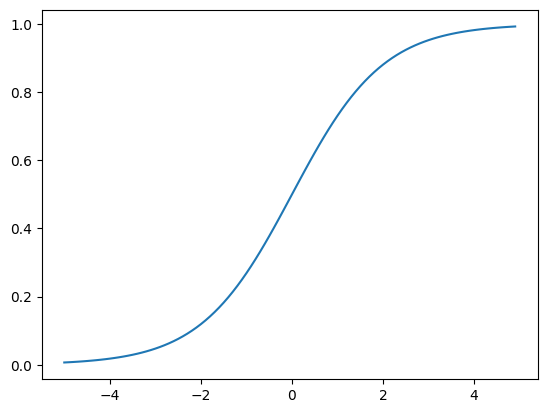

In [24]:
X = torch.arange(-5, 5, step=0.1)
y = nn.functional.sigmoid(X)
plt.plot(X, y)

We are changing only the loss function not the neuron. Keep in mind

In [25]:
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

cv = CountVectorizer(max_features=1000)
messages = cv.fit_transform(df["message"])

X = torch.tensor(messages.todense(), dtype=torch.float32)
y = torch.tensor(df["spam"], dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(1000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(loss)
model.eval()
with torch.no_grad():
    y_pred = model(X)
    print(y_pred)
    print(y_pred.min())
    print(y_pred.max())

tensor(0.7010, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5406, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4668, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4237, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3938, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3708, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3519, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3356, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3213, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3086, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2971, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2866, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2772, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2685, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2605, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2531, grad_fn=<BinaryCrossEntro

Still the output contains the negative values. increasing learning rate from 0.01 to 0.02

In [26]:
model = nn.Linear(1000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss)

model.eval()
with torch.no_grad():
    y_pred = nn.functional.sigmoid(model(X)) # model will be predicted and sent to sigmoid function to get the values from 0 to 1 only
    print(y_pred)
    print(y_pred.min())
    print(y_pred.max())

tensor(0.6967, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2245, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1639, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1366, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1205, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1097, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1018, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0957, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0908, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0867, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([[0.0126],
        [0.0212],
        [0.9727],
        ...,
        [0.0138],
        [0.0394],
        [0.0419]])
tensor(8.4896e-11)
tensor(0.9999)


Now how to evaluate the model with performance metrics

In [27]:
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

cv = CountVectorizer(max_features=1000)
messages = cv.fit_transform(df["message"])

X = torch.tensor(messages.todense(), dtype=torch.float32)
y = torch.tensor(df["spam"], dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(1000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss)

model.eval()
with torch.no_grad():
    y_pred = nn.functional.sigmoid(model(X)) > 0.25
    print("accuracy:", (y_pred == y)\
        .type(torch.float32).mean())
    
    print("sensitivity:", (y_pred[y == 1] == y[y == 1])\
        .type(torch.float32).mean())
    
    print("specificity:", (y_pred[y == 0] == y[y == 0])\
        .type(torch.float32).mean())

    print("precision:", (y_pred[y_pred == 1] == y[y_pred == 1])\
        .type(torch.float32).mean()) 
   

tensor(0.6908, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2249, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1641, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1206, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1098, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1018, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0957, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0908, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0867, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
accuracy: tensor(0.9799)
sensitivity: tensor(0.9224)
specificity: tensor(0.9888)
precision: tensor(0.9273)


In [28]:
print((y == 1).type(torch.float32).mean())
print((y == 0).type(torch.float32).mean())
print("======")
print((y_pred == 1).type(torch.float32).mean())
print((y_pred == 0).type(torch.float32).mean())

tensor(0.1341)
tensor(0.8659)
tensor(0.1333)
tensor(0.8667)


In [29]:
print((y[y == 1]).type(torch.float32).mean())
print((y[y == 0]).type(torch.float32).mean())
print("======")
print((y[y_pred == 1]).type(torch.float32).mean())
print((y[y_pred == 0]).type(torch.float32).mean())

tensor(1.)
tensor(0.)
tensor(0.9273)
tensor(0.0120)


In [30]:
print((y_pred[y == 1]).type(torch.float32).mean())
print((y_pred[y == 0]).type(torch.float32).mean())
print("======")
print((y_pred[y_pred == 1]).type(torch.float32).mean())
print((y_pred[y_pred == 0]).type(torch.float32).mean())

tensor(0.9224)
tensor(0.0112)
tensor(1.)
tensor(0.)


Let's train the model with training data and do the validation with validation data

In [31]:
import sys
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

df_train = df.sample(frac=0.8, random_state=0)
df_val = df.drop(index=df_train.index)

cv = CountVectorizer(max_features=5000)
messages_train = cv.fit_transform(df_train["message"])
messages_val = cv.transform(df_val["message"])

X_train = torch.tensor(messages_train.todense(), dtype=torch.float32)
y_train = torch.tensor(df_train["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

X_val = torch.tensor(messages_val.todense(), dtype=torch.float32)
y_val = torch.tensor(df_val["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(5000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [32]:
def evaluate_model(X, y): 
    model.eval()
    with torch.no_grad():
        y_pred = nn.functional.sigmoid(model(X)) > 0.25
        print("accuracy:", (y_pred == y)\
            .type(torch.float32).mean())
        
        print("sensitivity:", (y_pred[y == 1] == y[y == 1])\
            .type(torch.float32).mean())
        
        print("specificity:", (y_pred[y == 0] == y[y == 0])\
            .type(torch.float32).mean())

        print("precision:", (y_pred[y_pred == 1] == y[y_pred == 1])\
            .type(torch.float32).mean())

In [33]:
for i in range(0, 1000): # Change from 1000, 5000, to 10000 and see the differen
    # Training pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss) 
        
print("Evaluating on the training data")
evaluate_model(X_train, y_train)

print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

tensor(0.6970, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Evaluating on the training data
accuracy: tensor(0.9643)
sensitivity: tensor(0.8651)
specificity: tensor(0.9800)
precision: tensor(0.8723)
Evaluating on the validation data
accuracy: tensor(0.9614)
sensitivity: tensor(0.8561)
specificity: tensor(0.9764)
precision: tensor(0.8380)


In [34]:
for i in range(0, 5000): # Change from 1000, 5000, to 10000 and see the differen
    # Training pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss) 
        
print("Evaluating on the training data")
evaluate_model(X_train, y_train)

print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

tensor(0.2219, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1606, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1327, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1161, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1048, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Evaluating on the training data
accuracy: tensor(0.9773)
sensitivity: tensor(0.9178)
specificity: tensor(0.9868)
precision: tensor(0.9163)
Evaluating on the validation data
accuracy: tensor(0.9749)
sensitivity: tensor(0.9209)
specificity: tensor(0.9826)
precision: tensor(0.8828)


In [35]:
for i in range(0, 10000): # Change from 1000, 5000, to 10000 and see the differen
    # Training pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(loss)

print("Evaluating on the training data")
evaluate_model(X_train, y_train)

print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

tensor(0.0965, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0901, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0848, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0804, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0767, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0735, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0706, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0681, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0658, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0637, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Evaluating on the training data
accuracy: tensor(0.9838)
sensitivity: tensor(0.9375)
specificity: tensor(0.9912)
precision: tensor(0.9437)
Evaluating on the validation data
accuracy: tensor(0.9785)
sensitivity: tensor(0.9209)
specificity: tensor(0.9867)
precision: tensor(0.9078)


If you observe the above one, it has a good precision than others

Now the model is ready for testing

In [44]:
import sys
import torch
from torch import nn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

df_train = df.sample(frac=0.8, random_state=0)
df_val = df.drop(index=df_train.index)

cv = CountVectorizer(max_features=1000)
messages_train = cv.fit_transform(df_train["message"])
messages_val = cv.transform(df_val["message"])

X_train = torch.tensor(messages_train.todense(), dtype=torch.float32)
y_train = torch.tensor(df_train["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

X_val = torch.tensor(messages_val.todense(), dtype=torch.float32)
y_val = torch.tensor(df_val["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(1000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss)

def evaluate_model(X, y): 
    model.eval()
    with torch.no_grad():
        y_pred = nn.functional.sigmoid(model(X)) > 0.25
        print("accuracy:", (y_pred == y)\
            .type(torch.float32).mean())
        
        print("sensitivity:", (y_pred[y == 1] == y[y == 1])\
            .type(torch.float32).mean())
        
        print("specificity:", (y_pred[y == 0] == y[y == 0])\
            .type(torch.float32).mean())

        print("precision:", (y_pred[y_pred == 1] == y[y_pred == 1])\
            .type(torch.float32).mean()) 
        
print("Evaluating on the training data")
evaluate_model(X_train, y_train)

print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

custom_messages = cv.transform([
    "We have release a new product, do you want to buy it?", 
    "Winner! Great deal, call us to get this product for free",
    "Tomorrow is my birthday, do you come to the party?"
])

X_custom = torch.tensor(custom_messages.todense(), dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred = nn.functional.sigmoid(model(X_custom))
    print(pred)


tensor(0.7006, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2237, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1632, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1198, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1089, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1009, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0947, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0897, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0856, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Evaluating on the training data
accuracy: tensor(0.9791)
sensitivity: tensor(0.9211)
specificity: tensor(0.9883)
precision: tensor(0.9256)
Evaluating on the validation data
accuracy: tensor(0.9740)
sensitivity: tensor(0.9137)
specificity: tensor(0.9826)
precision: tensor(0.8819)
tensor([[0.0517],
        [0.6089],
        [0.0129]])


### Another way using transformers

Normal way to generate embeddings

In [37]:
from transformers import BartTokenizer, BartModel
import torch
from torch import nn

messages = [
    "We have release a new product, do you want to buy it?", 
    "Winner! Great deal, call us to get this product for free",
    "Tomorrow is my birthday, do you come to the party?",
]

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
out = tokenizer(messages)
print(out)

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

{'input_ids': [[0, 170, 33, 800, 10, 92, 1152, 6, 109, 47, 236, 7, 907, 24, 116, 2], [0, 46722, 328, 2860, 432, 6, 486, 201, 7, 120, 42, 1152, 13, 481, 2], [0, 38849, 16, 127, 4115, 6, 109, 47, 283, 7, 5, 537, 116, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [38]:
# Observe the padding difference
out = tokenizer(messages, padding=True)
print(out)

{'input_ids': [[0, 170, 33, 800, 10, 92, 1152, 6, 109, 47, 236, 7, 907, 24, 116, 2], [0, 46722, 328, 2860, 432, 6, 486, 201, 7, 120, 42, 1152, 13, 481, 2, 1], [0, 38849, 16, 127, 4115, 6, 109, 47, 283, 7, 5, 537, 116, 2, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [39]:
# Now it says to process only 512 tokens to process. Only 512 tokens not 512 characters. If it exceed 512 tokens do the truncation
out = tokenizer(messages, 
                padding=True, 
                max_length=512, 
                truncation=True) # 
print(out)

{'input_ids': [[0, 170, 33, 800, 10, 92, 1152, 6, 109, 47, 236, 7, 907, 24, 116, 2], [0, 46722, 328, 2860, 432, 6, 486, 201, 7, 120, 42, 1152, 13, 481, 2, 1], [0, 38849, 16, 127, 4115, 6, 109, 47, 283, 7, 5, 537, 116, 2, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [40]:
out = tokenizer(messages, 
                padding=True, 
                max_length=512, 
                truncation=True, 
                return_tensors="pt")

bart_model = BartModel.from_pretrained("facebook/bart-base")
with torch.no_grad():
    bart_model.eval()
    print(out)
    # print(*out)
    # pred = bart_model(**out) # This sentence is same as below
    pred = bart_model(
        input_ids=out["input_ids"], 
        attention_mask=out["attention_mask"]
    )
    print(pred.last_hidden_state.shape) 
    embeddings = pred.last_hidden_state.mean(dim=1)
    print(embeddings.shape)
    print(embeddings[0, :])

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

{'input_ids': tensor([[    0,   170,    33,   800,    10,    92,  1152,     6,   109,    47,
           236,     7,   907,    24,   116,     2],
        [    0, 46722,   328,  2860,   432,     6,   486,   201,     7,   120,
            42,  1152,    13,   481,     2,     1],
        [    0, 38849,    16,   127,  4115,     6,   109,    47,   283,     7,
             5,   537,   116,     2,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])}
torch.Size([3, 16, 768])
torch.Size([3, 768])
tensor([-4.1475e-01, -9.5950e-01, -1.9372e+00, -1.8202e+00, -1.3529e+00,
        -3.2617e-01, -4.3142e-02, -2.8496e-01, -4.4574e-01, -2.8201e+00,
        -7.7632e-01,  9.4289e-01,  3.7461e-01,  3.3576e-01,  5.2033e-01,
         7.1250e-01, -9.4961e-01,  7.0305e-01, -3.9577e-01, -1.0670e+00,
         2.0777e-01, -1.6843e-01, -1.0866e+00,  8.7861e-01,

torch.Size([3, 16, 768])
there are 3 dimensions here.
our LLM predicted 1 token at a time.
So it took 16 iterations for each sentence


torch.Size([3, 16, 768]) Breakdown:

3 — Batch size: You passed in a batch of 3 sequences (probably 3 sentences or documents).

16 — Sequence length: Each input sequence is padded or truncated to a length of 16 tokens.

768 — Hidden size: Each token in the sequence is represented by a 768-dimensional vector. This is a common hidden size for BART-base (similar to BERT-base).

what is last_hidden_state?

It's a tensor containing the final hidden layer's output for each token in each sequence.

You can think of it as a 3D matrix:\
For each of the 3 input sequences →\
For each of the 16 tokens in the sequence →\
There's a 768-dimensional vector representing the model's internal understanding at that position.

In [41]:
from transformers import BartTokenizer, BartModel
import torch
from torch import nn
from tqdm import tqdm

messages = [
    "We have release a new product, do you want to buy it?", 
    "Winner! Great deal, call us to get this product for free",
    "Tomorrow is my birthday, do you come to the party?",
]
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartModel.from_pretrained("facebook/bart-base")

def convert_to_embeddings(messages):
    embeddings_list = []
    for message in tqdm(messages):
        out = tokenizer([message], 
                        padding=True,
                        max_length=512, 
                        truncation=True, 
                        return_tensors="pt")

        with torch.no_grad():
            bart_model.eval()

            pred = bart_model(
                input_ids=out["input_ids"], 
                attention_mask=out["attention_mask"]
            )
            embeddings = pred.last_hidden_state.mean(dim=1)\
                .reshape((-1)) # It is going to matrix ([1, 768]) to a vector([768]) or tensor, so it can be easily processed by the neuron 
            embeddings_list.append(embeddings)
    return torch.stack(embeddings_list)
X = convert_to_embeddings(messages)
print(X.shape)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.84it/s]

torch.Size([3, 768])


Now implement this code in the neuron. Here instead of Count Vectorizer we are using Bart model. The reason it works more accurate because it is working with meanings(LLM embeddings) not just the words(CV)

In [42]:
import sys
import torch
from torch import nn
import pandas as pd
from transformers import BartTokenizer, BartModel
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartModel.from_pretrained("facebook/bart-base")

def convert_to_embeddings(messages):
    embeddings_list = []
    for message in tqdm(messages):
        out = tokenizer([message], 
                        padding=True,
                        max_length=512, 
                        truncation=True, 
                        return_tensors="pt")

        with torch.no_grad():
            bart_model.eval()

            pred = bart_model(
                input_ids=out["input_ids"], 
                attention_mask=out["attention_mask"]
            )
            embeddings = pred.last_hidden_state.mean(dim=1)\
                .reshape((-1))
            embeddings_list.append(embeddings)
    return torch.stack(embeddings_list)

df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = df["type"] == "spam"
df.drop("type", axis=1, inplace=True)

df_train = df.sample(frac=0.8, random_state=0)
df_val = df.drop(index=df_train.index)

X_train = convert_to_embeddings(df_train["message"].tolist())
X_val = convert_to_embeddings(df_val["message"].tolist())

y_train = torch.tensor(df_train["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

y_val = torch.tensor(df_val["spam"].values, dtype=torch.float32)\
        .reshape((-1, 1))

model = nn.Linear(768, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

for i in range(0, 10000):
    # Training pass
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(loss)

def evaluate_model(X, y): 
    model.eval()
    with torch.no_grad():
        y_pred = nn.functional.sigmoid(model(X)) > 0.25
        print("accuracy:", (y_pred == y)\
            .type(torch.float32).mean())
        
        print("sensitivity:", (y_pred[y == 1] == y[y == 1])\
            .type(torch.float32).mean())
        
        print("specificity:", (y_pred[y == 0] == y[y == 0])\
            .type(torch.float32).mean())

        print("precision:", (y_pred[y_pred == 1] == y[y_pred == 1])\
            .type(torch.float32).mean()) 
        
print("Evaluating on the training data")
evaluate_model(X_train, y_train)

print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

X_custom = convert_to_embeddings([
    "We have release a new product, do you want to buy it?", 
    "Winner! Great deal, call us to get this product for free",
    "Tomorrow is my birthday, do you come to the party?"
])

model.eval()
with torch.no_grad():
    pred = nn.functional.sigmoid(model(X_custom))
    print(pred)


100%|██████████████████████████████████████████████████████████████████████████████| 1114/1114 [00:40<00:00, 27.47it/s]


tensor(0.6647, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0277, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0205, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0168, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0144, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0126, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0113, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0102, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0094, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0086, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Evaluating on the training data
accuracy: tensor(0.9984)
sensitivity: tensor(0.9984)
specificity: tensor(0.9984)
precision: tensor(0.9902)
Evaluating on the validation data
accuracy: tensor(0.9946)
sensitivity: tensor(0.9856)
specificity: tensor(0.9959)
precision: tensor(0.9716)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.38it/s]

tensor([[2.6850e-03],
        [8.0221e-01],
        [4.5402e-07]])


### Optional

In [43]:
import sys
import torch
from torch import nn
import pandas as pd
from transformers import BartTokenizer, BartModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the data
df = pd.read_csv("./data/SMSSpamCollection", 
                 sep="\t", 
                 names=["type", "message"])

df["spam"] = (df["type"] == "spam").astype(int)
df.drop("type", axis=1, inplace=True)

# Split the data
df_train, df_val = train_test_split(df, test_size=0.2, random_state=0)

# Load BART and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model_bart = BartModel.from_pretrained("facebook/bart-base")

# Tokenize messages with a progress bar
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), 
                     padding=True, 
                     truncation=True, 
                     return_tensors="pt", 
                     max_length=512)

# Transform training data with progress bar
print("Tokenizing and transforming training data...")
tokens_train = tokenize_texts(df_train["message"])
embeddings_train = []
for i in tqdm(range(len(tokens_train['input_ids']))):
    with torch.no_grad():
        output = model_bart(input_ids=tokens_train['input_ids'][i].unsqueeze(0), 
                            attention_mask=tokens_train['attention_mask'][i].unsqueeze(0))
        embeddings_train.append(output.last_hidden_state.mean(dim=1).squeeze(0))

# Transform validation data with progress bar
print("Tokenizing and transforming validation data...")
tokens_val = tokenize_texts(df_val["message"])
embeddings_val = []
for i in tqdm(range(len(tokens_val['input_ids']))):
    with torch.no_grad():
        output = model_bart(input_ids=tokens_val['input_ids'][i].unsqueeze(0), 
                            attention_mask=tokens_val['attention_mask'][i].unsqueeze(0))
        embeddings_val.append(output.last_hidden_state.mean(dim=1).squeeze(0))

# Stack the embeddings into tensors
X_train = torch.stack(embeddings_train)
y_train = torch.tensor(df_train["spam"].values, dtype=torch.float32).unsqueeze(1)

X_val = torch.stack(embeddings_val)
y_val = torch.tensor(df_val["spam"].values, dtype=torch.float32).unsqueeze(1)

# Define a simple linear model
model = nn.Linear(X_train.size(1), 1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

# Training loop
for i in range(10000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0: 
        print(f"Iteration {i}, Loss: {loss.item()}")

# Evaluation function
def evaluate_model(X, y): 
    model.eval()
    with torch.no_grad():
        y_pred = torch.sigmoid(model(X)) > 0.25
        accuracy = (y_pred == y).type(torch.float32).mean().item()
        sensitivity = (y_pred[y == 1] == y[y == 1]).type(torch.float32).mean().item()
        specificity = (y_pred[y == 0] == y[y == 0]).type(torch.float32).mean().item()
        precision = (y_pred[y_pred == 1] == y[y_pred == 1]).type(torch.float32).mean().item()
        
        print(f"Accuracy: {accuracy}")
        print(f"Sensitivity: {sensitivity}")
        print(f"Specificity: {specificity}")
        print(f"Precision: {precision}")

# Evaluate on training data
print("Evaluating on the training data")
evaluate_model(X_train, y_train)

# Evaluate on validation data
print("Evaluating on the validation data")
evaluate_model(X_val, y_val)

# Custom messages for prediction
custom_messages = pd.Series([
    "We have released a new product, do you want to buy it?", 
    "Winner! Great deal, call us to get this product for free",
    "Tomorrow is my birthday, do you want to come to the party?"
])

tokens_custom = tokenize_texts(custom_messages)
embeddings_custom = []
print("Transforming custom messages...")
for i in tqdm(range(len(tokens_custom['input_ids']))):
    with torch.no_grad():
        output = model_bart(input_ids=tokens_custom['input_ids'][i].unsqueeze(0), 
                            attention_mask=tokens_custom['attention_mask'][i].unsqueeze(0))
        embeddings_custom.append(output.last_hidden_state.mean(dim=1).squeeze(0))

X_custom = torch.stack(embeddings_custom)
with torch.no_grad():
    model.eval()
    pred = torch.sigmoid(model(X_custom))
    print(pred)


Tokenizing and transforming training data...


100%|██████████████████████████████████████████████████████████████████████████████| 4457/4457 [11:36<00:00,  6.40it/s]


Tokenizing and transforming validation data...


100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [02:19<00:00,  7.98it/s]


Iteration 0, Loss: 0.7211135029792786
Iteration 1000, Loss: 0.035095930099487305
Iteration 2000, Loss: 0.026426220312714577
Iteration 3000, Loss: 0.02208225429058075
Iteration 4000, Loss: 0.019298294559121132
Iteration 5000, Loss: 0.017310665920376778
Iteration 6000, Loss: 0.01579560525715351
Iteration 7000, Loss: 0.014586646109819412
Iteration 8000, Loss: 0.013588636182248592
Iteration 9000, Loss: 0.012743335217237473
Evaluating on the training data
Accuracy: 0.9961857795715332
Sensitivity: 0.9948892593383789
Specificity: 0.9963824152946472
Precision: 0.9765886068344116
Evaluating on the validation data
Accuracy: 0.9901345372200012
Sensitivity: 0.981249988079071
Specificity: 0.991623044013977
Precision: 0.9515151381492615
Transforming custom messages...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.16it/s]

tensor([[0.9989],
        [0.9997],
        [0.0357]])
